# Process Realtime Data

In [1]:
#pip install geopy
#pip install geo-py

In [2]:
# Import all required modules
import pandas as pd
#import random
import numpy as np
#import pprint
import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt
from datetime import datetime

import math

import os
import time # Used for playing around with timers. 
from sys import getsizeof # Used for checking how much memory a variable is using. 
import geopy.distance


from functools import reduce
from geographiclib.geodesic import Geodesic

## GTFS - Static

##### Import the GTFS - static data and take a look at it

In [3]:
# The GTFS-static data is already available to us in the (hidden) 'gtfs_static_2020' folder
# If we start with '/' we go up to the top of the directory folder
pathname = '/course/data/gtfs_static_2020'

# Let's see what we have available in the (hidden) 'gtfs_static_2020' folder

# For every file that is in the list in the directory print out the name of the file
for file in os.listdir(pathname):
    print(file, ";", str(os.path.getsize(pathname+'/'+file)/1000)+' kb')
# Even thoough the data set is hidden we can still access it
# At the end we have the size of the file. The default unit is 'bytes'



stop_times.txt ; 358097.839 kb
trips.txt ; 22010.921 kb
calendar.txt ; 167.91 kb
routes.txt ; 802.772 kb
stops.txt ; 4529.801 kb
agency.txt ; 11.23 kb
notes.txt ; 96.399 kb
calendar_dates.txt ; 988.769 kb


In [4]:
agencydf = pd.read_csv(pathname+'/'+'agency.txt')
#agencydf.head(3)


In [5]:
tripsdf = pd.read_csv(pathname+'/'+'trips.txt')
tripsdf.head(3)

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id,block_id,wheelchair_accessible,route_direction,trip_note,bikes_allowed
0,1-31B-M-sj2-4,AA51+1,1.AA51.1-31B-M-sj2-4.2.R,1-31B-M-sj2-4.2.R,Mount Victoria,1,NaN,2,"Lithgow, then Mount Victoria",NaN,NaN
1,1-31B-M-sj2-4,AA51+1,2.AA51.1-31B-M-sj2-4.2.R,1-31B-M-sj2-4.2.R,Mount Victoria,1,NaN,2,"Lithgow, then Mount Victoria",NaN,NaN
2,1-31B-M-sj2-4,AA51+1,3.AA51.1-31B-M-sj2-4.2.R,1-31B-M-sj2-4.2.R,Mount Victoria,1,NaN,2,"Lithgow, then Mount Victoria",NaN,NaN


In [6]:
#tripsdf = pd.read_csv(pathname+'/'+'trips.txt')
#tripsdf = tripsdf.astype(str)
#tripsdf['direction_id'] = tripsdf['direction_id'].astype(int)
#tripsdf.dtypes

In [7]:
caldf = pd.read_csv(pathname+'/'+'calendar.txt')
#caldf.head(3)

In [8]:
cal_datesdf = pd.read_csv(pathname+'/'+'calendar_dates.txt')
#cal_datesdf.head(3)

In [9]:
stopsdf = pd.read_csv(pathname+'/'+'stops.txt')
stopsdf.head(3)

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,platform_code
0,228055,228055.0,Pacific Hwy After Murray St,-33.003610,151.685566,NaN,NaN,0,NaN
1,228054,228054.0,Pacific Hwy Opp Ntaba Rd,-33.006195,151.684612,NaN,NaN,0,NaN
2,287146,287146.0,Flint St At Oxford St,-33.392373,148.014977,NaN,NaN,0,NaN


In [10]:
stop_timesdf = pd.read_csv(pathname+'/'+'stop_times.txt',dtype = str)
#stop_timesdf.head(3)


In [11]:
#stop_timesdf.dtypes

In [12]:
#stop_timesdf[stop_timesdf['trip_id'].str.contains('1061421') & stop_timesdf['stop_id'].str.contains('206123')]

In [13]:
routesdf = pd.read_csv(pathname+'/'+'routes.txt')
#routesdf.head(3)

# Make a list of routes that are part of the Sydney Buses Network-- ditching trains, ferry, light rail. There is too much data to import all trips (even just 15 seconds of it)
#busroutes = routesdf[routesdf['route_desc']=='Sydney Buses Network']['route_id'].tolist()


In [14]:
#tripsdf = pd.read_csv(pathname+'/'+'trips.txt')
#tripsdf.head(3)

# Narrow it down to only trips belonging to bus routes. 
#tripsdf=tripsdf[tripsdf['route_id'].isin(busroutes)]

### Stop List for Military Road, Victoria Rd and Paramatta Road

In [15]:
# Get all the stops on Victoria Road
df_vic = stopsdf[stopsdf.stop_name.str.startswith('Victoria Rd')][['stop_id', 'stop_lat', 'stop_lon']]

# The end points
left_lat_lon = [-33.797348, 151.004453]
right_lat_lon = [-33.869001, 151.176395]


lon_min = min(left_lat_lon[1],right_lat_lon[1])
lon_max = max(left_lat_lon[1],right_lat_lon[1])

lat_min = min(left_lat_lon[0],right_lat_lon[0])
lat_max = max(left_lat_lon[0],right_lat_lon[0])

# All the stops on a 'Victoria Rd' that is within the endpoint of the Victoria Road that we want
df_vic = df_vic[(df_vic['stop_lat'] < lat_max) & (df_vic['stop_lat'] > lat_min) & (df_vic['stop_lon'] < lon_max) & (df_vic['stop_lon'] > lon_min)]

# Save and check using this website: http://www.hamstermap.com/quickmap.php
#df_vic.to_csv('lat_long3', index = False)

In [16]:
# Get all the stops on Parramatta Road
df_parr = stopsdf[stopsdf.stop_name.str.startswith('Parramatta Rd')][['stop_id', 'stop_lat', 'stop_lon']]

# Save and check using this website: http://www.hamstermap.com/quickmap.php
#df_parr.to_csv('lat_long4', index = False)

# Considering the map with all the lat/long points it appears that the list of points doesnt need to be refined further

In [17]:
# Get all the stops on Military Road
df_mil = stopsdf[stopsdf.stop_name.str.startswith('Military Rd')][['stop_id', 'stop_lat', 'stop_lon']]

# The end points
left_lat_lon = [-33.832889, 151.215521]
right_lat_lon = [-33.823721, 151.248244]


lon_min = min(left_lat_lon[1],right_lat_lon[1])
lon_max = max(left_lat_lon[1],right_lat_lon[1])

lat_min = min(left_lat_lon[0],right_lat_lon[0])
lat_max = max(left_lat_lon[0],right_lat_lon[0])

# All the stops on a 'Victoria Rd' that is within the endpoint of the Victoria Road that we want
df_mil = df_mil[(df_mil['stop_lat'] < lat_max) & (df_mil['stop_lat'] > lat_min) & (df_mil['stop_lon'] < lon_max) & (df_mil['stop_lon'] > lon_min)]
#df_mil

# Save and check using this website: http://www.hamstermap.com/quickmap.php
#df_mil.to_csv('lat_long5', index = False)

In [18]:
# List of main bus stops on military road
stopslist_military1 = [2088178, 208913, 208914, 208948, 208871, 208818, 
             2088180, 2088243, 2088176, 209058, 209036, 2088192, 
             209019, 208944, 209019, 208960]

stopslist_military2 = df_mil['stop_id'].astype(str).tolist()
stopslist_military = np.unique(stopslist_military1 + stopslist_military2).tolist()

stopslist_vict = df_vic['stop_id'].astype(str).tolist()
stopslist_parra = df_parr['stop_id'].astype(str).tolist()



### Routes in Study

In [19]:
stopslist = stopslist_military

In [20]:
# Get the stop times for all the buses that stop at the bus stop in 'stopslist'
print(len(stop_timesdf))
stop_timesdf_sample = stop_timesdf[stop_timesdf.stop_id.isin(stopslist)]
print(len(stop_timesdf_sample))

4575283
27718


In [21]:
# List of unique trip ids for all the buses that stop at the bus stops in 'stopslist'
triplist = stop_timesdf_sample['trip_id'].unique().astype(str).tolist()
# Note: this should be the trip ids for those buses that actually have 'stop times'

In [22]:
# We're only interested in the trips for those routes that have stops in 'stopslist'
tripsdf_sample = tripsdf[tripsdf['trip_id'].isin(triplist)] 
#tripsdf.head()

In [23]:
# Make a list that contains routes of buses that have stops in 'stopslist'
routelist = tripsdf_sample['route_id'].unique().tolist()

In [24]:
#routelist

In [25]:
# Make dataframe from routesdf containing only the routes using Military Road
routesdf = routesdf[routesdf['route_id'].isin(routelist)]
#routesdf.head()

In [26]:
# Only consider routes that are part of the 'Sydney BUses Network'
military_Routesdf = routesdf[routesdf['route_desc'] == 'Sydney Buses Network']
military_Routesdf.head(5)
#military_Routesdf

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color,exact_times
1779,26-257-sj2-1,2439,257,PrePay-Only - Balmoral to Chatswood via Crows ...,Sydney Buses Network,700,00B5EF,FFFFFF,1
2042,28-143-sj2-1,2440,143,PrePay-Only - Manly to Chatswood via Balgowlah...,Sydney Buses Network,700,00B5EF,FFFFFF,1
2043,28-144-sj2-1,2440,144,PrePay-Only - Manly to Chatswood via Royal Nor...,Sydney Buses Network,700,00B5EF,FFFFFF,1
2046,28-151-sj2-1,2440,151,PrePay-Only - Mona Vale to City QVB,Sydney Buses Network,700,00B5EF,FFFFFF,1
2051,28-168-sj2-1,2440,168,PrePay-Only - North Balgowlah to Milsons Point,Sydney Buses Network,700,00B5EF,FFFFFF,1


In [27]:
# Route id list using 'route_short_name'
military_RouteIdLIST = military_Routesdf.route_short_name.astype(str).tolist()

# Route id list using 'route_id'
military_RouteIdLIST_LONG = military_Routesdf.route_id.astype(str).tolist()

len(military_RouteIdLIST)

46

In [28]:
# Now that we have all the routes that we want copy over the original tripsdf by filtering it using all the
# routes that we're interested in.

tripsdf = tripsdf[tripsdf.route_id.isin(military_RouteIdLIST_LONG)]
#tripsdf

# Do the same with stop_timesdf.
triplist_forStopTimes = tripsdf['trip_id'].unique().tolist()
stop_timesdf = stop_timesdf[stop_timesdf['trip_id'].isin(triplist_forStopTimes)]
#stop_timesdf


In [29]:
#military_RouteIdLIST

## GTFS - Realtime

### Cut Down Realtime Data to only Relevant Infomation

In [30]:
# Import Big CSV file
##filename_SBN = '20200512_0805_TripUpdates_SBN_ALL.csv'
##df_TU = pd.read_csv(filename_SBN, dtype = str)


In [31]:
# Convert arrival time to string containing actual time in time format
# Add 10h of seconds to get right timezone
##df_TU['arr_time'] = df_TU['arr_time'].map(lambda x: (datetime.utcfromtimestamp(int(x) + 10*60**2).strftime('%H:%M:%S')))

In [32]:
##df_TU.sort_values('arr_time').head(2)

In [33]:
# Lets see what range of arrival times that we have.
# Add 10h of seconds to get right timezone
##dummydf = df_TU[df_TU.route_id.str.contains('B1')].sort_values('start_time')
##dummydf.head(2)

In [34]:
##dummydf.sort_values('arr_time').head(2)

In [35]:
# Get the route short name and then filter the big df so that we only get the route ids that we're interested in
##df_TU['route_short_name'] = df_TU['route_id'].map(lambda x: x.split('_')[1])
##df_TU = df_TU[df_TU.route_short_name.isin(military_RouteIdLIST)]

# How many updates are available
##len(df_TU)

In [36]:
# How many routes have updates
##routesWithUpdates = df_TU.route_short_name.unique().tolist()
##len(routesWithUpdates)

In [37]:
#df_TU.head(2)

In [38]:
# Save the condensed dataframe
##pathname_MTR = '/home/Military Trip Updates'
##filename_MTR = filename_SBN[:-11] + 'MILITARY.csv'
##df_TU.to_csv(os.path.join(pathname_MTR, filename_MTR), index = False)

### Import and Inspect Filtered Realtime

In [39]:
#os.listdir(pathname_MTR)
#os.listdir(pathname_MTR)[0]

In [40]:
# Import CSV file
pathname_MTR = '/home/Military Trip Updates'

# Run this line if filtered trip updates is being used directly
filename_MTR = '20200505_0835_TripUpdates_MILITARY.csv'

df_TU = pd.read_csv(pathname_MTR+'/'+filename_MTR,dtype = str)
df_TU.head(2)

#len(df_TU)

,Unnamed: 0,trip_id,route_id,stop_id,stop_seq,start_time,start_date,arr_time,arr_delay,dep_time,dep_delay,route_short_name
0,19120,1061421,2440_230,206058,26,08:07:00,20200505,08:34:52,-488,1588631712,-468,230
1,19121,1061421,2440_230,206123,27,08:07:00,20200505,08:35:48,-492,1588631776,-464,230


In [41]:
#df_TU[df_TU.trip_id =='645213']
#df_TU[df_TU.stop_seq =='0']
(int(df_TU.dep_time.max()) - int(df_TU.dep_time.min()))/60/60

1.1111111111111112

In [42]:
# Go through column names and if there are any columns with 'Unnamed' in it then remove it
collist = df_TU.columns.values.tolist()

for colName in collist:
    if 'Unnamed' in colName:
        collist.remove(colName)
df_TU = df_TU[collist]

df_TU.drop(['start_time','dep_time','start_date','stop_seq'], axis = 1, inplace=True)
df_TU.head(3)

,trip_id,route_id,stop_id,arr_time,arr_delay,dep_delay,route_short_name
0,1061421,2440_230,206058,08:34:52,-488,-468,230
1,1061421,2440_230,206123,08:35:48,-492,-464,230
2,1061421,2440_230,206125,08:37:27,-513,-497,230


In [43]:
'''df_TU['arr_delay_td'] = df_TU.arr_delay.map(lambda x: dt.timedelta(seconds = int(x)))
df_TU['dep_delay_td'] = df_TU.dep_delay.map(lambda x: dt.timedelta(seconds = int(x)))

df_TU.dtypes'''

"df_TU['arr_delay_td'] = df_TU.arr_delay.map(lambda x: dt.timedelta(seconds = int(x)))\ndf_TU['dep_delay_td'] = df_TU.dep_delay.map(lambda x: dt.timedelta(seconds = int(x)))\n\ndf_TU.dtypes"

In [44]:
# Consider only the services that correspond to collected trips
TU_tripIdList = df_TU['trip_id'].unique().tolist()
#TU_tripIdList

# Get the service ids that correspond to these trip_ids
TU_ServiceList = tripsdf[tripsdf['trip_id'].isin(TU_tripIdList)]['service_id'].unique().tolist()
#TU_ServiceList

In [45]:
# !!!Determine the nominal headway & bus in-front from 'stop_timesdf'!!!
# Get parts of 'stop_timesdf' and 'tripsdf' that we need
df1 = stop_timesdf[['trip_id', 'arrival_time', 'stop_sequence', 'stop_id']]
df2 = tripsdf[tripsdf['service_id'].isin(TU_ServiceList)][['route_id', 'trip_id', 'direction_id']]

# Construct df for calculating headways
stopsdf_headwy = pd.merge(df1, df2, how = 'inner', on = 'trip_id')
stopsdf_headwy.head()

,trip_id,arrival_time,stop_sequence,stop_id,route_id,direction_id
0,1138606,06:52:00,1,206718,26-257-sj2-1,0
1,1138606,06:53:00,2,206730,26-257-sj2-1,0
2,1138606,06:54:00,3,206731,26-257-sj2-1,0
3,1138606,06:55:00,4,206732,26-257-sj2-1,0
4,1138606,06:55:00,5,206733,26-257-sj2-1,0


In [46]:
# Filter out arrival times that we don't want and convert arrival times to datetimes 
# Filter out arrival times that are greater than 23:59
stopsdf_headwy['drop_me'] = stopsdf_headwy['arrival_time'].map(lambda x: int(str(x)[:2])-24)

# Nothing after 9pm
# Nothing before 6am
# Nothing between 11 am - 2pm

# Only consider times that are less than 23:59
stopsdf_headwy = stopsdf_headwy[(stopsdf_headwy['drop_me']<0)]
#stopsdf_headwy = stopsdf_headwy[(stopsdf_headwy['drop_me']<-3) & (stopsdf_headwy['drop_me']>-10) | ((stopsdf_headwy['drop_me']>-18) & (stopsdf_headwy['drop_me']<-13))]

# Add date to 'arrival_time' column then convert to datetime
date = filename_MTR[0:8]
#stopsdf_headwy['arrival_timedate'] = stopsdf_headwy['arrival_time'] + ' ' + date

#stopsdf_headwy
stopsdf_headwy['scheduled_arrival_time_dt'] = stopsdf_headwy['arrival_time'].map(lambda x: datetime.strptime(''.join((x, ' ', date)),'%H:%M:%S %Y%m%d'))

stopsdf_headwy.drop('drop_me', axis=1, inplace = True)

#stopsdf_headwy.head()

In [47]:
stopsdf_headwy.head()

,trip_id,arrival_time,stop_sequence,stop_id,route_id,direction_id,scheduled_arrival_time_dt
0,1138606,06:52:00,1,206718,26-257-sj2-1,0,2020-05-05 06:52:00
1,1138606,06:53:00,2,206730,26-257-sj2-1,0,2020-05-05 06:53:00
2,1138606,06:54:00,3,206731,26-257-sj2-1,0,2020-05-05 06:54:00
3,1138606,06:55:00,4,206732,26-257-sj2-1,0,2020-05-05 06:55:00
4,1138606,06:55:00,5,206733,26-257-sj2-1,0,2020-05-05 06:55:00


In [48]:
# Only consider the times 20 mins either side of all data collected

# First get the start and end time of the data that was collected
startTime_str = df_TU.sort_values('arr_time').reset_index(drop=True).iloc[0]['arr_time']
endTime_str = df_TU.sort_values('arr_time').reset_index(drop=True).iloc[len(df_TU)-1]['arr_time']

# Convert start and end time to a datetime
startTime_dt = datetime.strptime(''.join((str(startTime_str), ' ', date)),'%H:%M:%S %Y%m%d')
endTime_dt = datetime.strptime(''.join((str(endTime_str), ' ', date)),'%H:%M:%S %Y%m%d')

# Subtract 100 mins from start time and add 20 mins to end time to get all trips of interest in 'stopsdf_headwy'
# Later this time will be refined. We just need headway times for the buses at the start
bufferTime_before = dt.timedelta(seconds = 1*60*100)
bufferTime_after = dt.timedelta(seconds = 1*60*20)
startTimeHorizon_dt = startTime_dt - bufferTime_before
endTimeHorizon_dt = endTime_dt + bufferTime_after

# Filter 'stopsdf_headwy' to only consider the times between the time horizon
stopsdf_headwy = stopsdf_headwy[(stopsdf_headwy['scheduled_arrival_time_dt']>startTimeHorizon_dt) & (stopsdf_headwy['scheduled_arrival_time_dt']<endTimeHorizon_dt)]
#stopsdf_headwy.sort_values('scheduled_arrival_time_dt')

In [49]:
#df_TU.head(2)

In [50]:
# Ensure that the stop sequence is an integer for proper sorting
stopsdf_headwy.stop_sequence = stopsdf_headwy.stop_sequence.astype(int)

In [51]:
# In this cell the values of 'stopsdf_headwy' are sorted and the headway calculated
stopsdf_headwy.sort_values(['direction_id','route_id','stop_sequence','scheduled_arrival_time_dt'],ascending = (True,True,True,False),inplace=True)
stopsdf_headwy.head()

,trip_id,arrival_time,stop_sequence,stop_id,route_id,direction_id,scheduled_arrival_time_dt
506,1137635,09:44:00,1,206718,26-257-sj2-1,0,2020-05-05 09:44:00
464,1137634,09:22:00,1,206718,26-257-sj2-1,0,2020-05-05 09:22:00
968,1138040,09:02:00,1,206718,26-257-sj2-1,0,2020-05-05 09:02:00
1052,1138087,08:42:00,1,206718,26-257-sj2-1,0,2020-05-05 08:42:00
1010,1138086,08:22:00,1,206718,26-257-sj2-1,0,2020-05-05 08:22:00


In [52]:
#stopsdf_headwy[['direction_id','route_id','stop_sequence']].iloc[i].values.tolist()

In [53]:
# Initialise empty column for calculation of nominal headways
stopsdf_headwy['headway_nominal'] = np.nan

# Reset index for loop below.
stopsdf_headwy.reset_index(drop = True, inplace = True)

In [54]:
# Go through the 'stopsdf_headwy' and calculate the nominal headways and the trip_id of the bus in front
index_nums = stopsdf_headwy.index.values.tolist()


for i in index_nums[:-1]:
    

    # If, this bus is NOT the last bus that will visit this stop from this route, AND/OR
    # this is NOT the only bus that visited this stop from this route. 
    # THEN, set the nominal headway will be calculated    
    if (stopsdf_headwy[['direction_id','route_id','stop_sequence']].iloc[i].values.tolist() == stopsdf_headwy[['direction_id','route_id','stop_sequence']].iloc[i+1].values.tolist()):
        # Calculate the nominal headway.
        # NOTE:
        # This calculation is only appropriate when the values for 
        # ['direction_id','route_id','stop_sequence'] 
        # are the same as those in the next row.
        # This is not the case if this is the last bus that visited that stop from this route, OR
        # This is the only bus that visited this stop from this route.
        stopsdf_headwy.at[i,'headway_nominal'] = stopsdf_headwy.at[i, 'scheduled_arrival_time_dt'] - stopsdf_headwy.at[i+1, 'scheduled_arrival_time_dt']    

#stopsdf_headwy

In [55]:
#stopsdf_headwy.head()

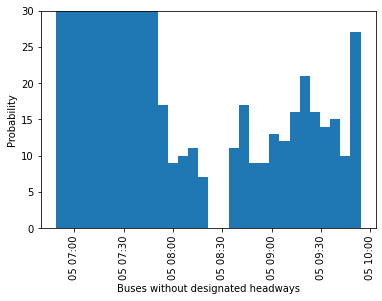

In [56]:
# Check how many NaN results there are.
plt.hist(stopsdf_headwy[(stopsdf_headwy['headway_nominal'].isnull())]['scheduled_arrival_time_dt'],bins = 30,density = False)
# What is the probability that a given stop time ..FILL IN.. is true
plt.xticks(rotation=90)
plt.xlabel('Buses without designated headways')
plt.ylabel('Probability')
plt.ylim(0,30)
plt.show()

In [57]:
# Make 'route_short_name' column - will need this for later
stopsdf_headwy['route_short_name'] = stopsdf_headwy['route_id'].str.split('-').str[1]

In [58]:
# Rename 'arrival_time' in 'df_TU to be 'arr_time'
stopsdf_headwy.rename(columns = {'arrival_time':'arr_time'},inplace=True)

In [59]:
# Initialise columns in 'stopsdf_headwy' that we need in df_TU

# Initially assume that there is zero delay
stopsdf_headwy['arr_delay'] = 0
stopsdf_headwy['dep_delay'] = 0

In [60]:
# Drop the 'route_id' column in the 'df_TU' dataframe. The route id column will come from 'stopsdf_headwy'
df_TU.drop('route_id', axis=1, inplace = True)

In [61]:
#df_TU.dtypes

In [62]:
#stopsdf_headwy['updated'] = np.NaN

# Define a loop that goes through and inputs every value of df_TU into stopsdf_headway
index_nums3 = df_TU.index.values.tolist()

for i in index_nums3:
    
    # Index in stopsdf_headwy that needs to be changed
    j = int(stopsdf_headwy[['trip_id','stop_id']].isin(df_TU[['trip_id','stop_id']].iloc[i].values.tolist()).sort_values(['trip_id','stop_id']).last_valid_index())
    
    # Input realtime values into stopsdf_headway values for 
    #stopsdf_headwy['arr_time'].iloc[j] = df_TU['arr_time'].iloc[i]
    #stopsdf_headwy['arr_delay'].iloc[j] = df_TU['arr_delay'].iloc[i]
    #stopsdf_headwy['dep_delay'].iloc[j] = df_TU['dep_delay'].iloc[i]
    stopsdf_headwy.at[j, 'arr_time'] = df_TU.at[i, 'arr_time']
    stopsdf_headwy.at[j, 'arr_delay'] = df_TU.at[i, 'arr_delay']
    stopsdf_headwy.at[j, 'dep_delay'] = df_TU.at[i, 'dep_delay']
    

    
    #print([i,j])
    
    del(j)


In [63]:
#stopsdf_headwy[stopsdf_headwy['arr_delay'] != 0].head(3)
#stopsdf_headwy.sort_values('updated',ascending=True)

In [64]:
# Prepare df for obtaining trip direction at the end of this code
# Make a column in 'stopsdf_headwy' that indicates if we're on MTR or not
stopsdf_headwy['is_on_MTR'] = stopsdf_headwy['stop_id'].isin(stopslist)

stopsdf_headwy.head(3)

,trip_id,arr_time,stop_sequence,stop_id,route_id,direction_id,scheduled_arrival_time_dt,headway_nominal,route_short_name,arr_delay,dep_delay,is_on_MTR
0,1137635,09:44:00,1,206718,26-257-sj2-1,0,2020-05-05 09:44:00,0 days 00:22:00,257,0,0,False
1,1137634,09:22:00,1,206718,26-257-sj2-1,0,2020-05-05 09:22:00,0 days 00:20:00,257,0,0,False
2,1138040,09:02:00,1,206718,26-257-sj2-1,0,2020-05-05 09:02:00,0 days 00:20:00,257,0,0,False


In [65]:
# Convert arrival and departure delays to datetimes
stopsdf_headwy['arr_delay_td'] = stopsdf_headwy.arr_delay.map(lambda x: dt.timedelta(seconds = int(x)))
stopsdf_headwy['dep_delay_td'] = stopsdf_headwy.dep_delay.map(lambda x: dt.timedelta(seconds = int(x)))

#df_TU.dtypes

In [66]:
stopsdf_headwy.head(3)

,trip_id,arr_time,stop_sequence,stop_id,route_id,direction_id,scheduled_arrival_time_dt,headway_nominal,route_short_name,arr_delay,dep_delay,is_on_MTR,arr_delay_td,dep_delay_td
0,1137635,09:44:00,1,206718,26-257-sj2-1,0,2020-05-05 09:44:00,0 days 00:22:00,257,0,0,False,0 days,0 days
1,1137634,09:22:00,1,206718,26-257-sj2-1,0,2020-05-05 09:22:00,0 days 00:20:00,257,0,0,False,0 days,0 days
2,1138040,09:02:00,1,206718,26-257-sj2-1,0,2020-05-05 09:02:00,0 days 00:20:00,257,0,0,False,0 days,0 days


In [67]:
# Determine the actual time that the bus 'arrived' at the stop
stopsdf_headwy['actual_arrival_time_dt'] = stopsdf_headwy['scheduled_arrival_time_dt'] + stopsdf_headwy['arr_delay_td']
#df_TU

In [68]:
# Condense df_TU dataframe by removing some columns
#df_TU_condensed = df_TU.drop(['Unnamed: 0.1', 'start_date', 'arr_time', 'dep_time', 'start_time'], axis=1)
df_TU_condensed = stopsdf_headwy.drop(['arr_time'], axis=1).copy()

In [69]:
# Take a look at what we have
df_TU_condensed.head(3)

,trip_id,stop_sequence,stop_id,route_id,direction_id,scheduled_arrival_time_dt,headway_nominal,route_short_name,arr_delay,dep_delay,is_on_MTR,arr_delay_td,dep_delay_td,actual_arrival_time_dt
0,1137635,1,206718,26-257-sj2-1,0,2020-05-05 09:44:00,0 days 00:22:00,257,0,0,False,0 days,0 days,2020-05-05 09:44:00
1,1137634,1,206718,26-257-sj2-1,0,2020-05-05 09:22:00,0 days 00:20:00,257,0,0,False,0 days,0 days,2020-05-05 09:22:00
2,1138040,1,206718,26-257-sj2-1,0,2020-05-05 09:02:00,0 days 00:20:00,257,0,0,False,0 days,0 days,2020-05-05 09:02:00


In [70]:
# How many rows is there no info for
print(len(df_TU_condensed[df_TU_condensed.scheduled_arrival_time_dt.isnull()]))

0


In [71]:
# Ensure that the stop sequence is an integer value for proper sorting
#df_TU_condensed.stop_sequence = df_TU_condensed.stop_sequence.astype(int)

In [72]:
# Sort 'df_TU_condensed' for calculation of actual headways
df_TU_condensed = df_TU_condensed.sort_values(['direction_id','route_short_name','stop_sequence','actual_arrival_time_dt'],ascending = (True,True,True,False))

#df_TU_condensed[df_TU_condensed.stop_sequence.isnull()]
#df_TU_condensed.tail(5)

In [73]:
# If the nominal headway could be merged in with the stop_timesdf,
# then, the actual headway could be calculated from nominal headway + delay_bus_behind + delay_bus_in_front,
# and, we wouldn't have to assume anything about last services at stops
# and, we could import directly the trip in front

In [74]:
# Cast df_TU_condensed['headway_nominal'] as a timedelta
df_TU_condensed['headway_nominal'] = pd.to_timedelta(df_TU_condensed['headway_nominal'])

# Initialise empty column for calculation of actual headways
df_TU_condensed['headway_actual'] = df_TU_condensed['headway_nominal']

df_TU_condensed['bunching_0.25hwy'] = np.nan
df_TU_condensed['bunchingBehind_0.25hwy'] = np.nan
df_TU_condensed['bunching_0.3hwy'] = np.nan


# Intialise empty column for bus in front
df_TU_condensed['bus_infront_tripID'] = np.nan

# Set min allowable headway for bunching
minHeadwayForBunching = dt.timedelta(seconds = 90)

# Reset index for loop below.
df_TU_condensed.reset_index(inplace = True, drop=True)

In [75]:
index_nums2 = df_TU_condensed.index.values.tolist()

for i in index_nums2[:-1]:
    
    # If, this bus is NOT the last bus that will visit this stop from this route, AND/OR
    # this is NOT the only bus that visited this stop from this route. 
    # THEN, set the nominal headway will be calculated    
    
    if (df_TU_condensed[['direction_id','route_id','stop_sequence']].iloc[i].values.tolist() == df_TU_condensed[['direction_id','route_id','stop_sequence']].iloc[i+1].values.tolist()):
        # Calculate the nominal headway.
        # NOTE:
        # This calculation is only appropriate when the values for 
        # ['direction_id','route_id','stop_seq'] 
        # are the same as those in the next row.
        # This is not the case if this is the last bus that visited that stop from this route, OR
        # This is the only bus that visited this stop from this route.
        
        df_TU_condensed.at[i,'headway_actual'] = df_TU_condensed.at[i,'actual_arrival_time_dt'] - df_TU_condensed.at[i+1,'actual_arrival_time_dt']
                
        df_TU_condensed.at[i,'bus_infront_tripID'] = df_TU_condensed.at[i+1,'trip_id']
        #df_TU_condensed['headway_actual'].iloc[i] = df_TU_condensed['headway_nominal'].iloc[i] - (df_TU_condensed['arr_delay_td'].iloc[i+1] - df_TU_condensed['arr_delay_td'].iloc[i])
        # ^ Code above has a problem when one bus overtakes another

    # Define bus bunching as the situation where the headway is:
    #     either less than 1/4 * nominal_headway, or 
    #     less than 1.5 mins.
    # Make a column called 'bus bunching' that contains a '1' if there is bus bunching and a '0' if there isn't bus bunching.    
    if (df_TU_condensed.at[i,'headway_actual'] <= 0.25*df_TU_condensed.at[i,'headway_nominal']):#|(df_TU_condensed['headway_actual'].iloc[i] < minHeadwayForBunching):
        df_TU_condensed.at[i,'bunching_0.25hwy'] = 1
        df_TU_condensed.at[i+1,'bunchingBehind_0.25hwy'] = 1
        
       
    # It is implicitly assumed that trips that are the last to finish are not bunching
    else:
        df_TU_condensed.at[i,'bunching_0.25hwy'] = 0
        df_TU_condensed.at[i+1,'bunchingBehind_0.25hwy'] = 0


        
    # What happens if headway = max(0.3hwy, 1.5 min) is the metric for measuring bus bunching
    if (df_TU_condensed.at[i,'headway_actual'] <= 0.3*df_TU_condensed.at[i,'headway_nominal']):#|(df_TU_condensed['headway_actual'].iloc[i] < minHeadwayForBunching):
        df_TU_condensed.at[i,'bunching_0.3hwy'] = 1

        
    # It is implicitly assumed that trips that are the last to finish are not bunching
    else:
        df_TU_condensed.at[i,'bunching_0.3hwy'] = 0
        

        
# The loop misses the last row for bunching assessment because we dont know when the bus in front got there
# Assume that it is not bunching.
df_TU_condensed.at[max(index_nums2),'bunching_0.25hwy'] = 0
df_TU_condensed.at[max(index_nums2),'bunching_0.3hwy'] = 0

df_TU_condensed.at[min(index_nums2),'bunchingBehind_0.25hwy'] = 0

#### Clean Up & Inspect Result

In [76]:
#df_TU_condensed['bunchingBehind_0.25hwy'].iloc[min(index_nums2)] = 0

In [77]:
#df_TU_condensed.head(1)

In [78]:
#df_TU_condensed[(df_TU_condensed['bunching_0.25hwy'] == 1)]# & (df_TU_condensed['bus_infront_tripID'].isnull())]
print(len(df_TU_condensed[df_TU_condensed['bunching_0.25hwy'] == 1]))

#df_TU_condensed[df_TU_condensed['bunching_0.3hwy'] == 1]
print(len(df_TU_condensed[df_TU_condensed['bunching_0.3hwy'] == 1]))

122
126


In [79]:
# Only consider the times 10 mins either side of all data collected

# Subtract 100 mins from start time and add 20 mins to end time to get all trips of interest in 'stopsdf_headwy'
# Later this time will be refined. We just need headway times for the buses at the start
bufferTime = dt.timedelta(seconds = 1*60*10)
startTimeHorizon_dt2 = startTime_dt - bufferTime
endTimeHorizon_dt2 = endTime_dt + bufferTime

# Filter 'df_TU_condensed' to only consider the times between the time horizons && 
# only take the rows where the nominal headway is not NaN or '0'
df_TU_export = df_TU_condensed[(df_TU_condensed['headway_nominal'] != dt.timedelta(seconds = 0)) & (df_TU_condensed['headway_nominal'].isnull() == False) & (df_TU_condensed['scheduled_arrival_time_dt']>startTimeHorizon_dt2) & (df_TU_condensed['scheduled_arrival_time_dt']<endTimeHorizon_dt2)]

# Check how many rows of data there are
len(df_TU_export)

6115

In [80]:
# How many bunching instances are there
#df_TU_export[df_TU_export['bunching_0.25hwy'] == 1]
#df_TU_export[df_TU_export['arr_delay'] == 0]

print(len(df_TU_export[df_TU_export['bunching_0.25hwy'] == 1]))
print(len(df_TU_export[df_TU_export['bunching_0.3hwy'] == 1]))

#df_TU_export

40
44


In [81]:
#df_TU_export[df_TU_export.bus_infront_tripID.isnull() == 1]
#df_TU_export[df_TU_export['bus_infront_tripID'].isnull() == 0]
#df_TU_export.head(5)

In [82]:
# Drop the index column
# 'Index' column (Note: this is not the actual index that we're dropping)

collist = df_TU_export.columns.values.tolist()

for colName in collist:
    if 'index' in colName:
        collist.remove(colName)
df_TU_export = df_TU_export[collist]
df_TU_export.head(1)

,trip_id,stop_sequence,stop_id,route_id,direction_id,scheduled_arrival_time_dt,headway_nominal,route_short_name,arr_delay,dep_delay,is_on_MTR,arr_delay_td,dep_delay_td,actual_arrival_time_dt,headway_actual,bunching_0.25hwy,bunchingBehind_0.25hwy,bunching_0.3hwy,bus_infront_tripID
0,1060337,1,206717,28-143-sj2-1,0,2020-05-05 08:49:00,00:33:00,143,0,0,False,0 days,0 days,2020-05-05 08:49:00,00:33:00,0.0,0.0,0.0,1059316.0


#### Obtain and Merge-in MTR position and direction information for each trip

In [83]:
# Obtain the first and last stop on MTR from the stop sequence

# Check if any buses only have 1 stop on MTR - initialise a 'dummy_df' to use during working
dummy_df = stopsdf_headwy.copy()


# Find the buses that only have 1 stop on MTR and drop them from the dummy
# Drop all rows for which the number of stops on MTR is only 1

dummy_df2 = dummy_df[dummy_df['is_on_MTR'] == True].groupby(['trip_id', 'is_on_MTR']).count().sort_values('route_id').reset_index()
AtLeastTwoStopMTR_tripId_list = dummy_df2[dummy_df2['arr_time'] != 1]['trip_id'].tolist()

# Make more dummy_dfs that contain the first and last stop 
dummy_df3 = dummy_df[dummy_df['trip_id'].isin(AtLeastTwoStopMTR_tripId_list) & dummy_df['is_on_MTR'] == True].groupby('trip_id')['stop_sequence'].min().reset_index().sort_values('stop_sequence')
dummy_df4 = dummy_df[dummy_df['trip_id'].isin(AtLeastTwoStopMTR_tripId_list) & dummy_df['is_on_MTR'] == True].groupby('trip_id')['stop_sequence'].max().reset_index().sort_values('stop_sequence')

dummy_df3.rename(columns = {'stop_sequence':'First MTR Stop seq num'},inplace=True)
dummy_df4.rename(columns = {'stop_sequence':'Last MTR Stop seq num'},inplace=True)

#pd.merge(dummy_df, dummy_df3, dummy_df4, how = 'left', on = 'trip_id')
#dummy_df[]
dfs = [dummy_df[['trip_id', 'stop_sequence', 'stop_id', 'is_on_MTR']], dummy_df3, dummy_df4]

dummydf_5 = reduce(lambda left,right: pd.merge(left,right,on='trip_id'), dfs)
#dummydf_5= dummydf_5[(dummydf_5['First MTR Stop seq num'] == dummydf_5['stop_sequence']) | (dummydf_5['Last MTR Stop seq num'] == dummydf_5['stop_sequence'])]

dummydf_5_first = dummydf_5[dummydf_5['First MTR Stop seq num'] == dummydf_5['stop_sequence']]
#dummydf_5_first
dummydf_5_last = dummydf_5[dummydf_5['Last MTR Stop seq num'] == dummydf_5['stop_sequence']]
#dummydf_5_last

# Get lat and long values
dummydf_6_first = pd.merge(dummydf_5_first,stopsdf[['stop_id','stop_lat','stop_lon']], on = 'stop_id', how = 'left')
dummydf_6_last = pd.merge(dummydf_5_last,stopsdf[['stop_id','stop_lat','stop_lon']], on = 'stop_id', how = 'left')

# Make column names appropriate
dummydf_6_first.rename(columns = {'stop_id':'first_stop_id','stop_lat': 'first_stop_lat','stop_lon': 'first_stop_lon'},inplace=True)
dummydf_6_last.rename(columns = {'stop_id':'last_stop_id','stop_lat': 'last_stop_lat','stop_lon': 'last_stop_lon'},inplace=True)

#dummydf_6_first
#dummydf_6_last


In [84]:
dummydf_6_first.drop('stop_sequence',axis=1,inplace=True)
dummydf_6_last.drop(['stop_sequence','First MTR Stop seq num', 'Last MTR Stop seq num','is_on_MTR'],axis=1,inplace=True)

In [85]:
direction_df = pd.merge(dummydf_6_first,dummydf_6_last, on = 'trip_id', how = 'left')
direction_df.head(2)

,trip_id,first_stop_id,is_on_MTR,First MTR Stop seq num,Last MTR Stop seq num,first_stop_lat,first_stop_lon,last_stop_id,last_stop_lat,last_stop_lon
0,1137634,208947,True,27,30,-33.829879,151.218454,209058,-33.829481,151.227708
1,1138040,208947,True,27,36,-33.829879,151.218454,208847,-33.828807,151.244149


1. Determine the bearing between the two points
2. Assign direction number 

In [86]:
#Geodesic.WGS84.Inverse(-33.829879, 151.218454, -32, 150.244149)['azi1']

In [87]:
#direction_df

In [88]:
# 'dummydf_6' contains infomation on all the trips that use MTR
# Specifically infromation relating to the first and last stop on MTR as well as the coordinates of these stops is contained
# This will be used to calculated the bearing of each of these buses

# Calculate the bearing of the buses on military 
# Angles are from -180 to 180

direction_df['bearing'] = direction_df.apply(lambda x: Geodesic.WGS84.Inverse(x['first_stop_lat'], x['first_stop_lon'], x['last_stop_lat'], x['last_stop_lon'])['azi1'],axis=1)

#dummydf_6.sort_values('bearing')

Define:
- direction_number = 1 to be buses that travel with a south-west heading along MTR
- direction_number = 0 to be buses that travel with a north-east heading along MTR

In [89]:
# The direction of each trip can now be determined

direction_df['direction_number'] = np.where(direction_df['bearing'] < 0, 1, 0)

In [90]:
# Merge 'direction_df' with 'df_TU_export'
df_TU_export = pd.merge(df_TU_export,direction_df[['trip_id','direction_number']], how = 'left', on = 'trip_id')

In [91]:
# There is no direction number if the bus either (a) only has 1 stop on MTR, or
# (b) the bus started at a point that was either the last MTR stop or it never had a MTR stop
#     ^ these buses in b were helpful for calculating other headways but can be deleted now
df_TU_export = df_TU_export[(df_TU_export['direction_number'].isnull() == False)]

In [92]:
# Sort 'df_TU_export' in an ordered way before exporting
df_TU_export.sort_values(['route_id', 'direction_number', 'stop_sequence','scheduled_arrival_time_dt'],ascending = True, inplace=True)

In [93]:
df_TU_export.head(1)

,trip_id,stop_sequence,stop_id,route_id,direction_id,scheduled_arrival_time_dt,headway_nominal,route_short_name,arr_delay,dep_delay,is_on_MTR,arr_delay_td,dep_delay_td,actual_arrival_time_dt,headway_actual,bunching_0.25hwy,bunchingBehind_0.25hwy,bunching_0.3hwy,bus_infront_tripID,direction_number
1440,1138086,1,206718,26-257-sj2-1,0,2020-05-05 08:22:00,00:18:00,257,0,0,False,0 days,0 days,2020-05-05 08:22:00,00:18:00,0.0,0.0,0.0,1138088.0,0.0


In [94]:
# Get columns in appropriate order.
# Note if there are any other columns this will need to be updated
colOrder = ['route_id','route_short_name', 'trip_id', 'stop_sequence', 'stop_id', 'direction_number', 
 'is_on_MTR', 'scheduled_arrival_time_dt', 'headway_nominal', 'arr_delay', 'dep_delay',
 'arr_delay_td', 'dep_delay_td', 'actual_arrival_time_dt', 'headway_actual', 'bunching_0.25hwy', 'bunchingBehind_0.25hwy',
 'bunching_0.3hwy', 'bus_infront_tripID', 'direction_id']
df_TU_export = df_TU_export[colOrder].copy()

In [95]:
#df_TU_export.head(60)
# Delete some unnecessary columns before saving the dataframe
#df_TU_export.drop(['direction_id','dep_delay','dep_delay_td'], axis=1,inplace=True)
df_TU_export.drop(['direction_id'], axis=1,inplace=True)

### Save Data

In [96]:
pathname_df_TU_processed = '/home/Processed MTR Trip Updates'
filename_df_TU_processed = filename_MTR[:-4] + '_PROCESSED.pkl'

#df_TU_export.to_csv(os.path.join(pathname_df_TU_processed,'20200508_XXXX_TU_MILITARY_PROCESSED.csv'), index = False)

# SAVE AS PICKLE FILE TO PRESERVE DTYPES:
df_TU_export.to_pickle(os.path.join(pathname_df_TU_processed,filename_df_TU_processed))

In [97]:
#df_eg = pd.read_pickle(pathname_df_TU_processed+'/'+filename_df_TU_processed)
#df_eg.head()

In [98]:
# Save the direction information of all the trips as a .pkl file

##direction_df.to_pickle('Stop_and_Direction_Info_MTR.pkl')

In [99]:
#df_TU_export